In [ ]:
# Raw Dataset
!gdown 15-PtufoZq2Bz7Kjqh_DT54DWCwMsb4ZB
!unzip -q raw_datasets.zip -d datasets

Downloading...
From (original): https://drive.google.com/uc?id=15-PtufoZq2Bz7Kjqh_DT54DWCwMsb4ZB
From (redirected): https://drive.google.com/uc?id=15-PtufoZq2Bz7Kjqh_DT54DWCwMsb4ZB&confirm=t&uuid=4df459af-670f-4cbe-adda-f98b48d350cc
To: /content/raw_datasets.zip
100% 22.3M/22.3M [00:00<00:00, 151MB/s]
replace datasets/.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import (
    Input, LSTM, Bidirectional, Dense, Dropout,
    LayerNormalization, Concatenate, Lambda, Multiply)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, backend as K
import keras
keras.config.enable_unsafe_deserialization()
from keras.saving import register_keras_serializable

from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

In [ ]:
# Load and align closing prices from all available stock CSV files
base_dir = '/content/datasets/intraday_data'
symbol_dfs = {}
files = os.listdir(base_dir)
files.sort()
for file in files:
    if file.endswith('.csv'):
        symbol = file.replace('_intraday.csv', '')
        df = pd.read_csv(os.path.join(base_dir, file), parse_dates=['datetime'])
        df = df.sort_values('datetime').set_index('datetime')
        symbol_dfs[symbol] = df['close']

# Combine closing prices into a single DataFrame and remove rows with missing values
close_prices = pd.DataFrame(symbol_dfs).dropna(axis=0)

### Data Analysis

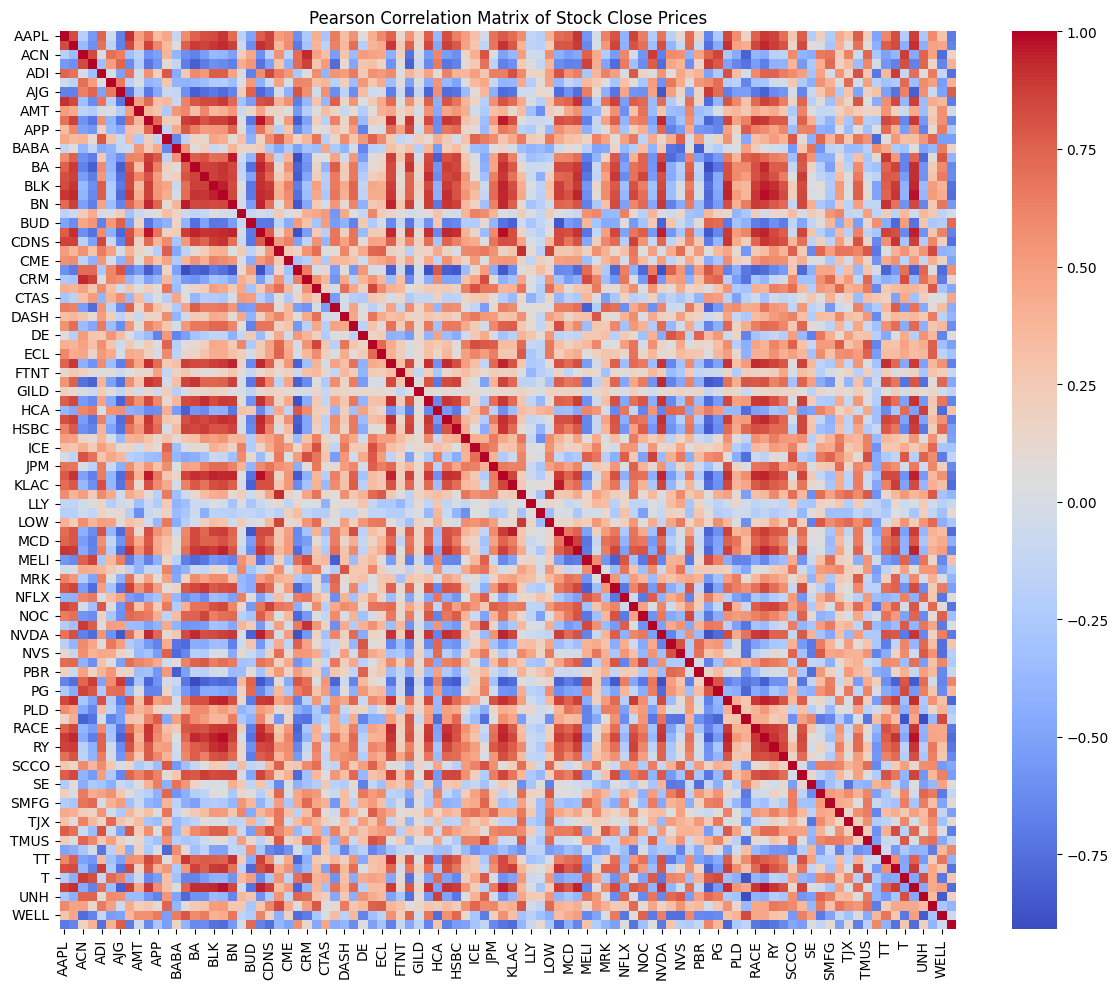

In [ ]:
# Visualize Pearson correlation matrix of stock close prices
correlation_matrix = close_prices.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Pearson Correlation Matrix of Stock Close Prices')
plt.tight_layout()
plt.show()

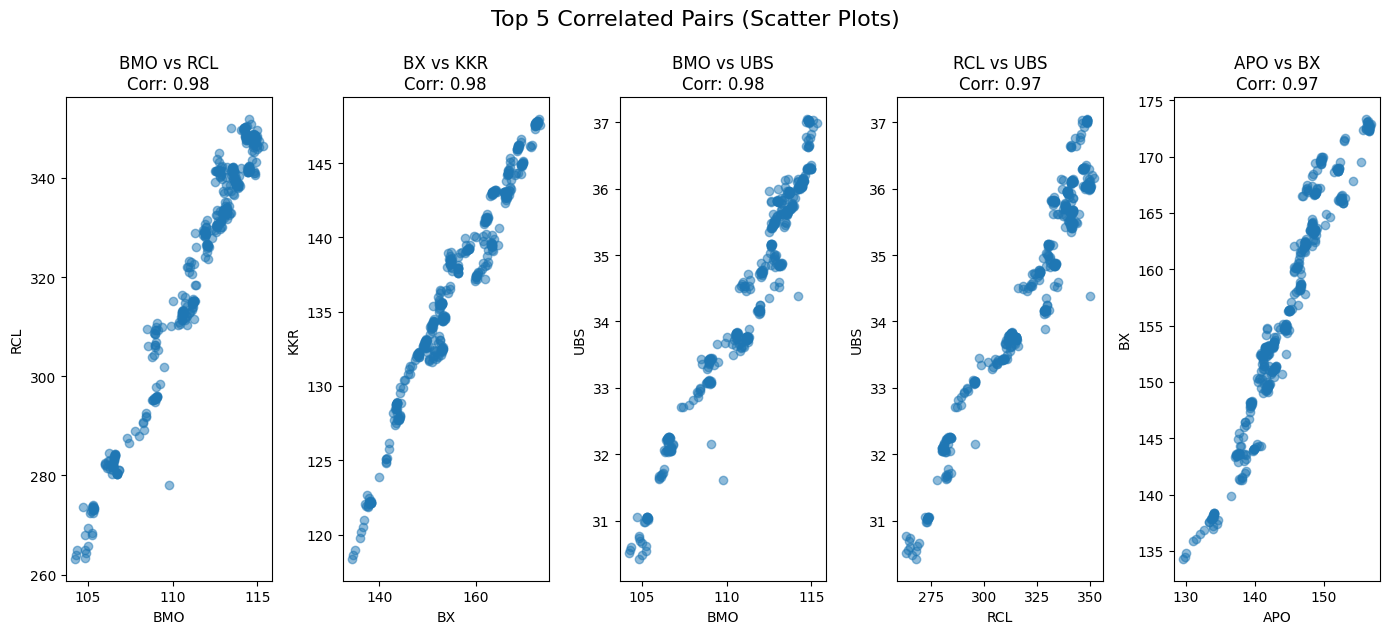

In [ ]:
# Identify stock pairs with high correlation based on a defined threshold
threshold = 0.9
high_corr_pairs = []
symbols = close_prices.columns.tolist()
for i in range(len(symbols)):
    for j in range(i + 1, len(symbols)):
        corr = correlation_matrix.loc[symbols[i], symbols[j]]
        if corr >= threshold:
            high_corr_pairs.append((symbols[i], symbols[j]))

# Visualize top 5 highly correlated pairs
top_corr_pairs = sorted(
    [(s1, s2, correlation_matrix.loc[s1, s2]) for s1, s2 in high_corr_pairs],
    key=lambda x: x[2],
    reverse=True
)[:5]

plt.figure(figsize=(14, 6))
for i, (s1, s2, corr) in enumerate(top_corr_pairs):
    plt.subplot(1, 5, i + 1)
    plt.scatter(close_prices[s1], close_prices[s2], alpha=0.5)
    plt.title(f'{s1} vs {s2}\nCorr: {corr:.2f}')
    plt.xlabel(s1)
    plt.ylabel(s2)
    plt.tight_layout()

plt.suptitle('Top 5 Correlated Pairs (Scatter Plots)', fontsize=16, y=1.05)
plt.show()


,Stock A,Stock B,p-value
0,BLK,BMO,0.000100
1,AAPL,AMGN,0.000200
2,ABNB,RCL,0.001100
3,BMO,RCL,0.001800
4,ABNB,BMO,0.002500
5,ABNB,BLK,0.004700
6,ABNB,UBS,0.005500
7,ABNB,PH,0.008100
8,BLK,UBS,0.010000
9,PH,RY,0.013400


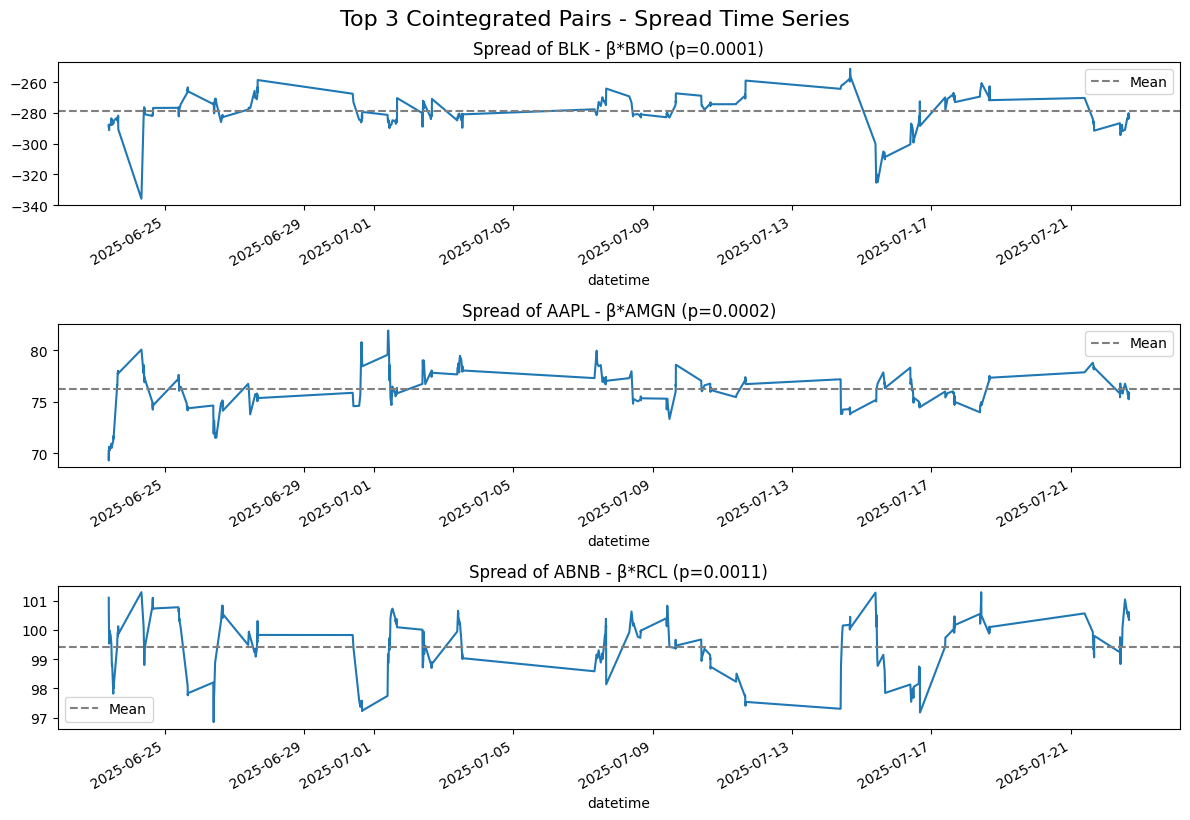

In [ ]:
# Perform Engle-Granger cointegration test on highly correlated pairs
cointegrated_pairs = []
for sym1, sym2 in high_corr_pairs:
    score, pvalue, _ = coint(close_prices[sym1], close_prices[sym2])
    if pvalue < 0.05:
        cointegrated_pairs.append((sym1, sym2, pvalue))

# Display cointegrated pairs sorted by statistical significance in a table
cointegrated_pairs = sorted(cointegrated_pairs, key=lambda x: x[2])
cointegration_df = pd.DataFrame(cointegrated_pairs, columns=['Stock A', 'Stock B', 'p-value'])

# Format p-value to 4 decimal places
cointegration_df['p-value'] = cointegration_df['p-value'].round(4)
from IPython.display import display
display(cointegration_df.style.set_caption("Statistically Significant Cointegrated Pairs (p < 0.05)"))



# Visualize spreads of top 3 cointegrated pairs
top_cointegrated = sorted(cointegrated_pairs, key=lambda x: x[2])[:3]
plt.figure(figsize=(12, 8))
for i, (s1, s2, pval) in enumerate(top_cointegrated):
    beta = np.polyfit(close_prices[s2], close_prices[s1], 1)[0]
    spread = close_prices[s1] - beta * close_prices[s2]
    plt.subplot(3, 1, i + 1)
    spread.plot()
    plt.title(f'Spread of {s1} - β*{s2} (p={pval:.4f})')
    plt.axhline(spread.mean(), color='gray', linestyle='--', label='Mean')
    plt.legend()
    plt.tight_layout()

plt.suptitle('Top 3 Cointegrated Pairs - Spread Time Series', fontsize=16, y=1.02)
plt.show()

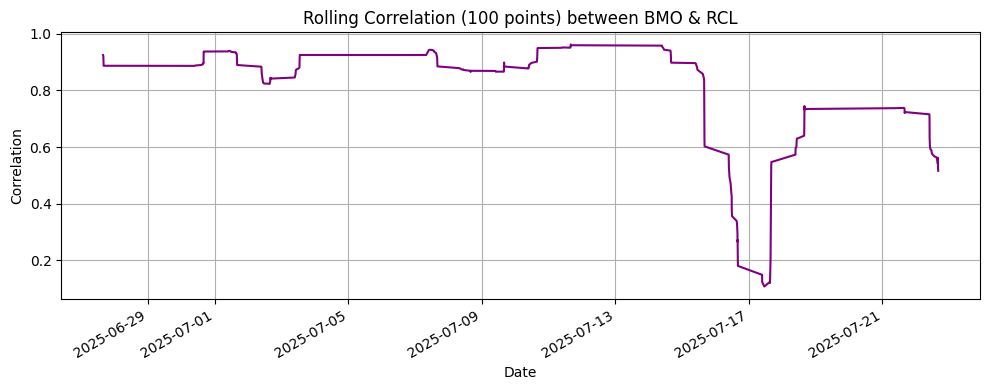

In [ ]:
# Rolling correlation for top correlated pair
top_pair = top_corr_pairs[0][:2]
rolling_corr = close_prices[top_pair[0]].rolling(window=100).corr(close_prices[top_pair[1]])

plt.figure(figsize=(10, 4))
rolling_corr.plot(color='purple')
plt.title(f'Rolling Correlation (100 points) between {top_pair[0]} & {top_pair[1]}')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.grid(True)
plt.tight_layout()
plt.show()


ADF Statistic: -5.2465
p-value: 0.0000


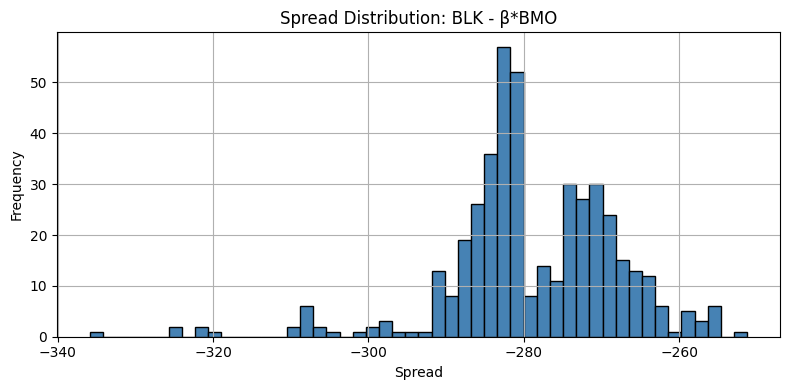

In [ ]:
# ADF test on spread of top cointegrated pair
s1, s2, _ = top_cointegrated[0]
beta = np.polyfit(close_prices[s2], close_prices[s1], 1)[0]
spread = close_prices[s1] - beta * close_prices[s2]

# Note -
# This supports the assumption required for statistical arbitrage
# and pair trading, where the spread's deviations from the mean can signal trading opportunities.
# Since the p-value is essentially zero, the result is highly reliable.
adf_result = adfuller(spread)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")

plt.figure(figsize=(8, 4))
spread.hist(bins=50, color='steelblue', edgecolor='black')
plt.title(f'Spread Distribution: {s1} - β*{s2}')
plt.xlabel('Spread')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

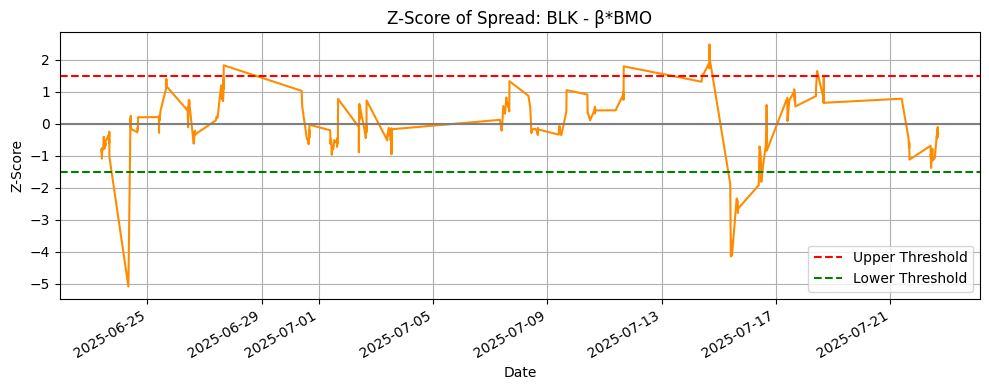

In [ ]:
# Z-Score Plot for Spread
z_score = (spread - spread.mean()) / spread.std()

plt.figure(figsize=(10, 4))
z_score.plot(color='darkorange')
plt.axhline(1.5, color='red', linestyle='--', label='Upper Threshold')
plt.axhline(-1.5, color='green', linestyle='--', label='Lower Threshold')
plt.axhline(0, color='gray', linestyle='-')
plt.title(f'Z-Score of Spread: {s1} - β*{s2}')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Feature Engineering

In [ ]:
# Feature Engineering for Cointegrated Pairs
feature_frames = []

# Define parameters
rolling_window = 20
momentum_window = 5
correlation_window = 50

# Loop through top 3 cointegrated pairs
for stock_a, stock_b, _ in cointegrated_pairs:
    beta = np.polyfit(close_prices[stock_b], close_prices[stock_a], 1)[0]
    spread = close_prices[stock_a] - beta * close_prices[stock_b]

    df = pd.DataFrame(index=spread.index)
    df['datetime'] = spread.index
    df['spread'] = spread
    df['zscore'] = (spread - spread.rolling(rolling_window).mean()) / spread.rolling(rolling_window).std()
    df['mean'] = spread.rolling(rolling_window).mean()
    df['std'] = spread.rolling(rolling_window).std()
    df['volatility'] = spread.rolling(rolling_window).std()
    df['momentum'] = spread - spread.shift(momentum_window)
    df['rolling_corr'] = close_prices[stock_a].rolling(correlation_window).corr(close_prices[stock_b])

    # Generate signal based on z-score thresholds
    def get_signal(z):
        if z > 1:
            return 0  # Neutral
        elif z > 0:
            return 1  # Short
        elif z < -0.5:
            return -1   # Long

    df['signal'] = df['zscore'].apply(get_signal)
    df['pair'] = f'{stock_a}_{stock_b}'

    feature_frames.append(df.dropna())

# Combine all pairs' features into one DataFrame
labeled_features  = pd.concat(feature_frames, ignore_index=True)

# Show the final feature set
print("Feature dataset shape:", labeled_features .shape)
labeled_features.head()

Feature dataset shape: (8675, 10)


,datetime,spread,zscore,mean,std,volatility,momentum,rolling_corr,signal,pair
0,2025-06-25 10:00:00,-277.634209,0.963003,-279.519263,1.957475,1.957475,-0.904443,0.750045,1.0,BLK_BMO
1,2025-06-25 10:01:00,-277.937593,0.906829,-279.605252,1.839001,1.839001,-1.288586,0.746758,1.0,BLK_BMO
2,2025-06-25 11:05:00,-274.272593,2.306565,-279.310107,2.183990,2.183990,5.188514,0.743337,0.0,BLK_BMO
3,2025-06-25 15:08:00,-267.459766,3.280553,-278.666435,3.416092,3.416092,14.721616,0.736269,0.0,BLK_BMO
4,2025-06-25 15:31:00,-266.940574,2.603480,-278.147061,4.304426,4.304426,9.286769,0.728246,0.0,BLK_BMO


### Modelling

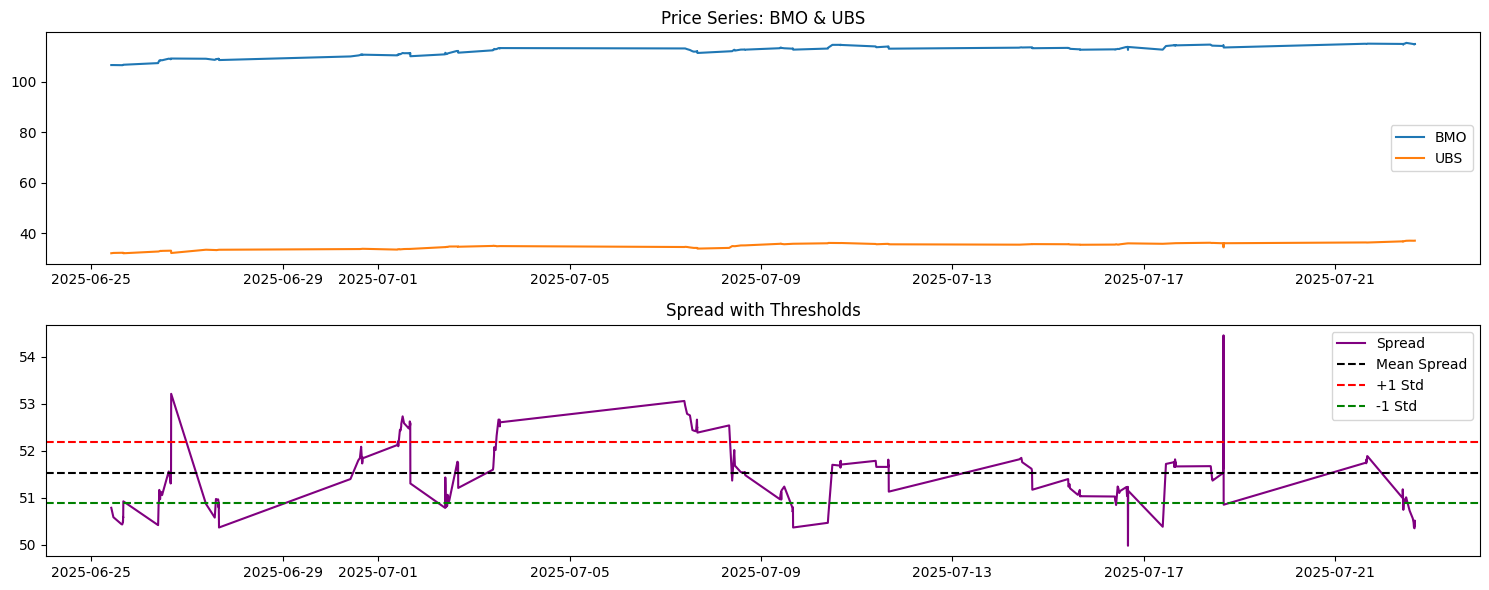

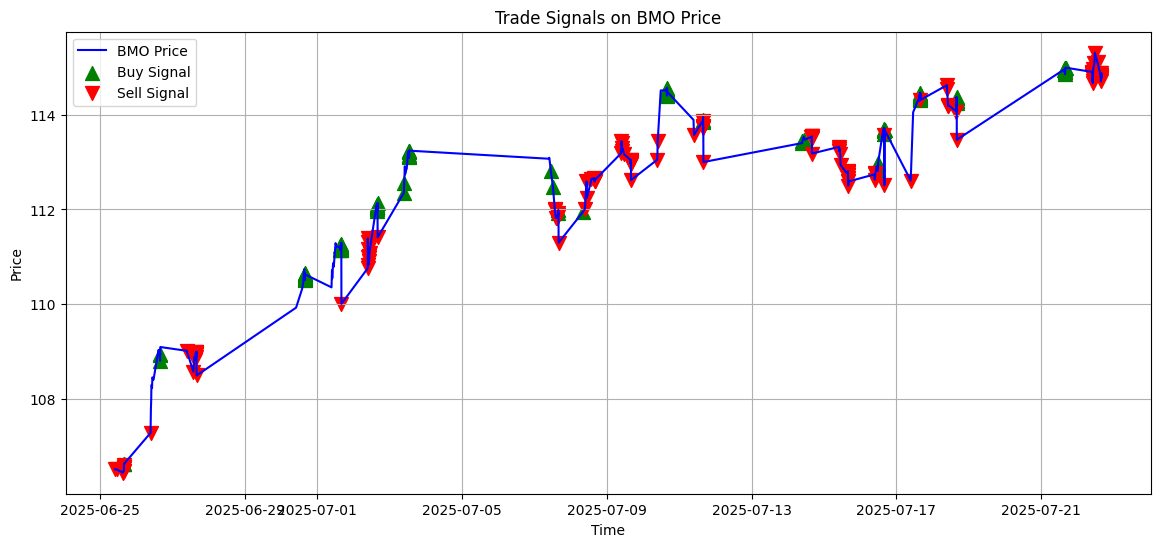

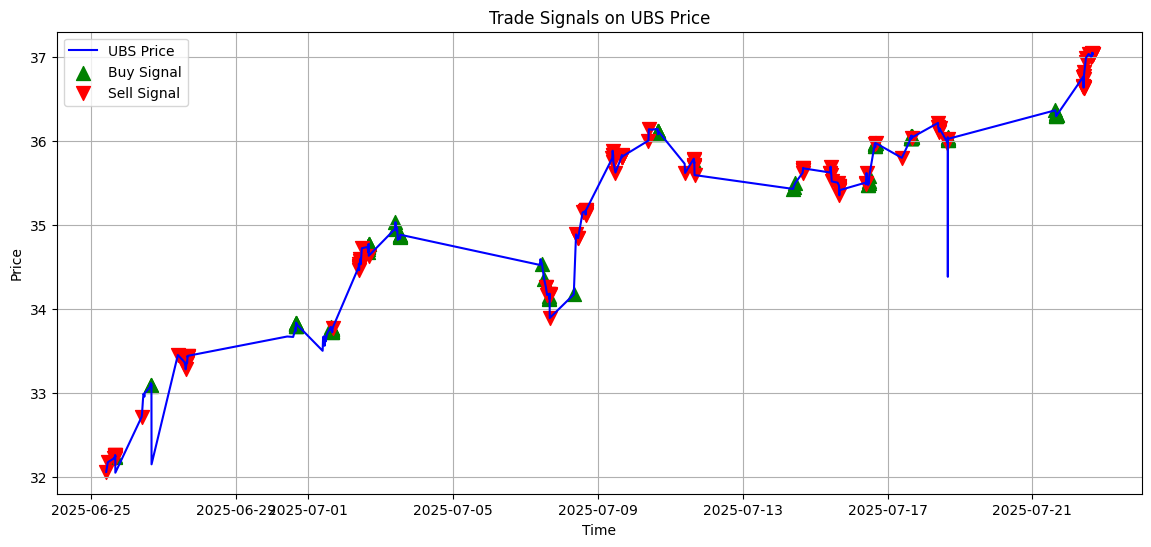

============ Ground Truth Backtest (Perfect Foresight) ============

--- Backtest Evaluation (Ground Truth (Perfect Signals)) ---
Total Profit: $2003.54
Cumulative Return: 20.04%
Sharpe Ratio (Annualized): 0.140
Maximum Drawdown: -14.06%
Number of Trades: 1086
Win Rate: 43.65%
Average P&L per Trade: 1.8442
-------------------------------------------



In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names, model_name="Model"):
    """Plots a visually appealing confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_roc_curve(y_true, y_pred_probs, class_names, model_name="Model"):
    """
    Plots the ROC curve for a multi-class classification model.
    Note: y_true should be integer labels, not one-hot encoded.
    """
    # Binarize the output labels for OvR (One-vs-Rest) approach
    y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
    n_classes = y_true_bin.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multi-class ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def backtest_with_predictions(test_df, predictions, initial_cash=10000, model_name="Model"):
    """
    Calculates:
    - Cumulative Returns
    - Sharpe Ratio
    - Maximum Drawdown
    - Win Rate
    - Average Trade P&L
    """
    cash = initial_cash
    position = 0  # 0: flat, 1: long, -1: short
    entry_spread = 0
    portfolio_value = []
    trade_pnl_list = []

    # Ensure the index is aligned for iteration
    test_df = test_df.reset_index(drop=True)

    for i in range(1, len(test_df)):
        # The signal for the *upcoming* period is from the previous day's prediction
        signal = predictions[i - 1]
        current_spread = test_df.loc[i, 'spread']

        # --- Position Management ---
        # Exit existing position if signal is neutral (0) or flips
        if position != 0:
            if signal == 0 or signal != position:
                if position == 1:  # Closing a long position
                    pnl = current_spread - entry_spread
                elif position == -1:  # Closing a short position
                    pnl = entry_spread - current_spread

                cash += pnl
                trade_pnl_list.append(pnl)
                position = 0  # Go flat

        # Enter new position if flat and signal is not neutral
        if position == 0:
            if signal == 1:  # Go long
                position = 1
                entry_spread = current_spread
            elif signal == -1:  # Go short
                position = -1
                entry_spread = current_spread

        # --- Portfolio Value Calculation ---
        # If in a position, current value is cash + unrealized P&L
        current_portfolio_value = cash
        if position == 1:
            current_portfolio_value += (current_spread - entry_spread)
        elif position == -1:
            current_portfolio_value += (entry_spread - current_spread)

        portfolio_value.append(current_portfolio_value)

    # --- Performance Metrics Calculation ---
    if not portfolio_value:
        print(f"\nBacktest Evaluation ({model_name}): No trades were made.")
        return None, {}

    portfolio_df = pd.DataFrame(portfolio_value, columns=['value'])
    total_profit = portfolio_df['value'].iloc[-1] - initial_cash
    cumulative_return = total_profit / initial_cash

    # Sharpe Ratio (using daily portfolio value changes)
    daily_returns = portfolio_df['value'].pct_change().dropna()
    sharpe_ratio = 0
    if daily_returns.std() > 0:
        # Assuming 252 trading days in a year for annualization
        sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)

    # Maximum Drawdown
    running_max = portfolio_df['value'].cummax()
    drawdown = (portfolio_df['value'] - running_max) / running_max
    max_drawdown = drawdown.min()

    # Trade-based Metrics
    win_rate = 0
    avg_trade_pnl = 0
    if trade_pnl_list:
        profitable_trades = sum(1 for pnl in trade_pnl_list if pnl > 0)
        win_rate = profitable_trades / len(trade_pnl_list)
        avg_trade_pnl = np.mean(trade_pnl_list)

    # --- Reporting ---
    print(f"\n--- Backtest Evaluation ({model_name}) ---")
    print(f"Total Profit: ${total_profit:.2f}")
    print(f"Cumulative Return: {cumulative_return:.2%}")
    print(f"Sharpe Ratio (Annualized): {sharpe_ratio:.3f}")
    print(f"Maximum Drawdown: {max_drawdown:.2%}")
    print(f"Number of Trades: {len(trade_pnl_list)}")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Average P&L per Trade: {avg_trade_pnl:.4f}")
    print("-------------------------------------------\n")

    return portfolio_df

def plot_model_signals(predictions, features_df, stock, close_prices, model_name="Model"):
    plt.figure(figsize=(14, 6))
    price_series = close_prices[stock].loc[features_df['datetime']]
    plt.plot(features_df['datetime'], price_series, label=f'{stock} Price', color='blue')

    buy_idx = np.where(predictions == 1)[0]
    sell_idx = np.where(predictions == -1)[0]

    plt.scatter(features_df.iloc[buy_idx]['datetime'], price_series.iloc[buy_idx],
                marker='^', color='green', label='Buy Signal', s=100)
    plt.scatter(features_df.iloc[sell_idx]['datetime'], price_series.iloc[sell_idx],
                marker='v', color='red', label='Sell Signal', s=100)

    plt.title(f'{model_name} Trade Signals on {stock} Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_price_and_spread(features_df, stock1, stock2, close_prices):
    plt.figure(figsize=(15, 6))

    plt.subplot(2, 1, 1)
    plt.plot(close_prices[stock1].loc[features_df['datetime']], label=stock1)
    plt.plot(close_prices[stock2].loc[features_df['datetime']], label=stock2)
    plt.title(f'Price Series: {stock1} & {stock2}')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(features_df['datetime'], features_df['spread'], label='Spread', color='purple')
    plt.axhline(features_df['spread'].mean(), color='black', linestyle='--', label='Mean Spread')
    plt.axhline(features_df['spread'].mean() + features_df['spread'].std(), color='red', linestyle='--', label='+1 Std')
    plt.axhline(features_df['spread'].mean() - features_df['spread'].std(), color='green', linestyle='--', label='-1 Std')
    plt.title('Spread with Thresholds')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_trades(features_df, stock, close_prices):
    plt.figure(figsize=(14, 6))
    price_series = close_prices[stock].loc[features_df['datetime']]
    plt.plot(features_df['datetime'], price_series, label=f'{stock} Price', color='blue')

    buy_signals = features_df[features_df['signal'] == 1]
    sell_signals = features_df[features_df['signal'] == -1]

    plt.scatter(buy_signals['datetime'], close_prices[stock].loc[buy_signals['datetime']], marker='^', color='green', label='Buy Signal', s=100)
    plt.scatter(sell_signals['datetime'], close_prices[stock].loc[sell_signals['datetime']], marker='v', color='red', label='Sell Signal', s=100)

    plt.title(f'Trade Signals on {stock} Price')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()


pair_df = labeled_features[labeled_features['pair'] == f'{stock_a}_{stock_b}']
plot_price_and_spread(pair_df, stock_a, stock_b, close_prices)
plot_trades(pair_df, stock_a, close_prices)
plot_trades(pair_df, stock_b, close_prices)

initial_cash = 10000
ground_truth_signals = labeled_features['signal'].values
print("============ Ground Truth Backtest (Perfect Foresight) ============")
portfolio_df = backtest_with_predictions(
    labeled_features,
    ground_truth_signals,
    initial_cash=initial_cash,
    model_name="Ground Truth (Perfect Signals)"
)

#### RANDOM FOREST AND XGBoost Training

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:27:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Random Forest Backtest Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       747
           1       1.00      1.00      1.00       420
           2       1.00      1.00      1.00       568

    accuracy                           1.00      1735
   macro avg       1.00      1.00      1.00      1735
weighted avg       1.00      1.00      1.00      1735


--- Backtest Evaluation (Model) ---
Total Profit: $456.94
Cumulative Return: 4.57%
Sharpe Ratio (Annualized): 0.461
Maximum Drawdown: -0.67%
Number of Trades: 215
Win Rate: 42.33%
Average P&L per Trade: 2.1218
-------------------------------------------



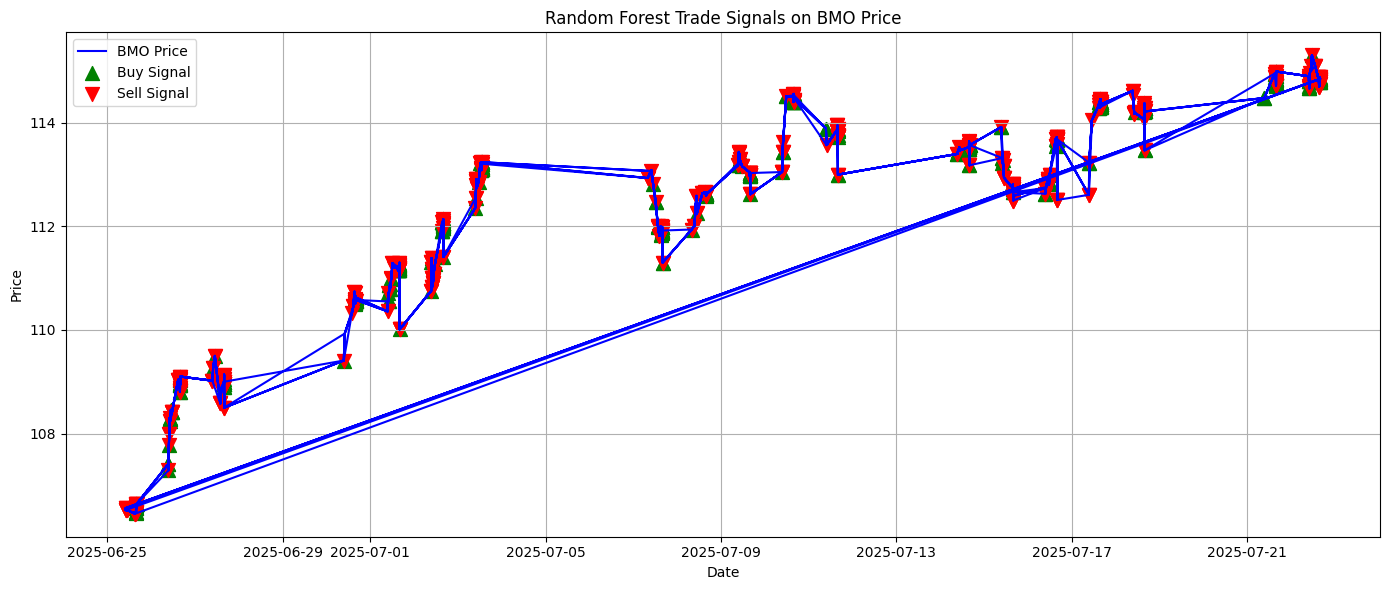

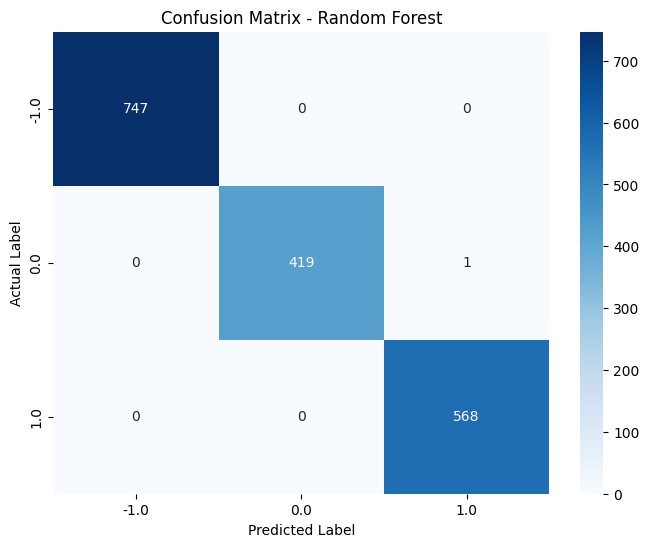

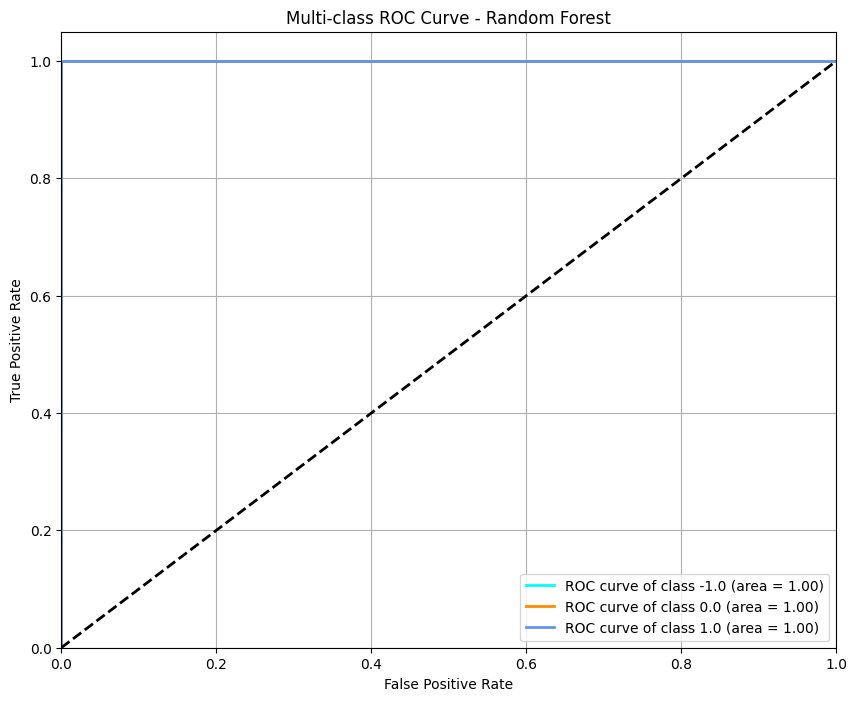




XGBoost Backtest Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       747
           1       1.00      0.99      1.00       420
           2       0.99      1.00      1.00       568

    accuracy                           1.00      1735
   macro avg       1.00      1.00      1.00      1735
weighted avg       1.00      1.00      1.00      1735


--- Backtest Evaluation (Model) ---
Total Profit: $457.00
Cumulative Return: 4.57%
Sharpe Ratio (Annualized): 0.461
Maximum Drawdown: -0.67%
Number of Trades: 215
Win Rate: 41.40%
Average P&L per Trade: 2.1220
-------------------------------------------



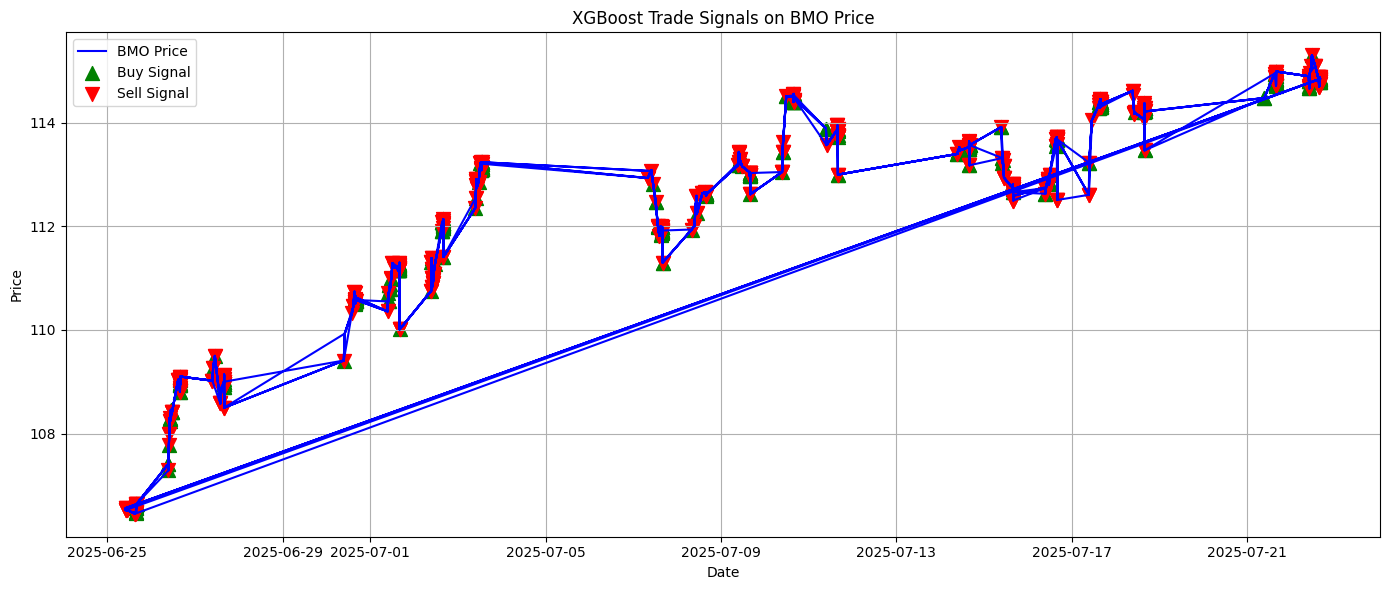

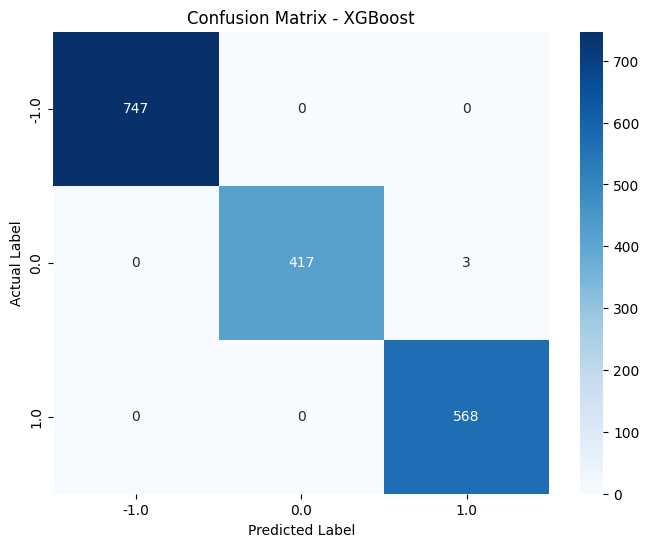

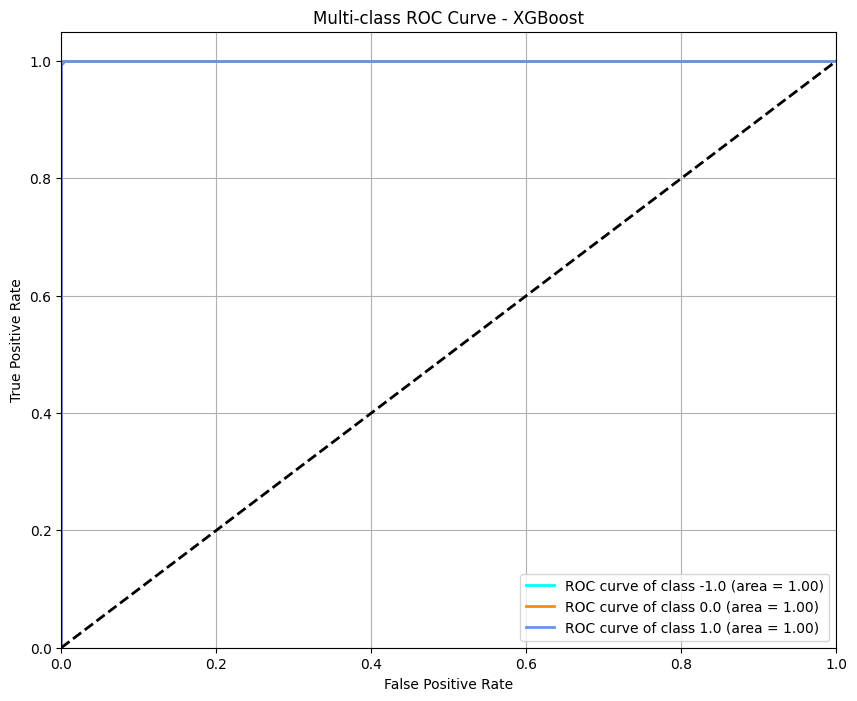

In [ ]:
def train_models(features_df):
    # Drop rows with NaNs
    features_df.dropna(inplace=True)

    # Define features and target
    feature_cols = ['spread', 'zscore', 'std', 'volatility', 'momentum', 'rolling_corr']
    X = features_df[feature_cols]
    y = features_df['signal']

    # Encode target variable
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, shuffle=False)

    # Initialize models
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)

    # Train models
    rf_model.fit(X_train, y_train)
    xgb_model.fit(X_train, y_train)

    # Predictions
    rf_pred_probs = rf_model.predict_proba(X_test)
    xgb_pred_probs = xgb_model.predict_proba(X_test)
    rf_preds = rf_model.predict(X_test)
    xgb_preds = xgb_model.predict(X_test)

    # Decode predictions back to original labels for reporting
    rf_preds_decoded = le.inverse_transform(rf_preds)
    xgb_preds_decoded = le.inverse_transform(xgb_preds)
    class_labels = le.classes_


    # Evaluation
    print("Random Forest Backtest Report:")
    print(classification_report(y_test, rf_preds))
    rf_backtest = backtest_with_predictions(features_df.iloc[X_test.index], rf_preds_decoded)
    plot_model_signals(rf_preds_decoded, features_df.iloc[X_test.index], stock_a, close_prices, model_name="Random Forest")
    plot_confusion_matrix(y_test, rf_preds, class_names=class_labels, model_name="Random Forest")
    plot_roc_curve(y_test, rf_pred_probs, class_names=class_labels, model_name="Random Forest")

    print('\n')
    print('='*200)

    print("\nXGBoost Backtest Report:")
    print(classification_report(y_test, xgb_preds))
    xgb_backtest = backtest_with_predictions(features_df.iloc[X_test.index], xgb_preds_decoded)
    plot_model_signals(xgb_preds_decoded, features_df.iloc[X_test.index], stock_a, close_prices, model_name="XGBoost")
    plot_confusion_matrix(y_test, xgb_preds, class_names=class_labels, model_name="XGBoost")
    plot_roc_curve(y_test, xgb_pred_probs, class_names=class_labels, model_name="XGBoost")

    return rf_model, xgb_model

rf_model, xgb_model = train_models(labeled_features)

#### RNN Model Training

Epoch 1/30
107/109 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5470 - loss: 1.0028
Epoch 1: val_accuracy improved from -inf to 0.73426, saving model to best_rnn_model.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5490 - loss: 0.9993 - val_accuracy: 0.7343 - val_loss: 0.6921
Epoch 2/30
105/109 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6953 - loss: 0.7503
Epoch 2: val_accuracy improved from 0.73426 to 0.74292, saving model to best_rnn_model.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6959 - loss: 0.7495 - val_accuracy: 0.7429 - val_loss: 0.6623
Epoch 3/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7173 - loss: 0.7090
Epoch 3: val_accuracy did not improve from 0.74292
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7174 - loss: 0.7091 - val_accuracy: 0.7371 - val_loss: 0.6629
Epoch 4/30
104/109 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7364 - loss: 0.6910
Epoch 4: val_accuracy improved from 0.74292 to 0.76141, saving mode

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'attention_layer', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

LSTM Backtest Report:
              precision    recall  f1-score   support

        -1.0       0.88      0.86      0.87       747
         0.0       0.75      0.65      0.70       417
         1.0       0.68      0.77      0.72       567

    accuracy                           0.78      1731
   macro avg       0.77      0.76      0.76      1731
weighted avg       0.78      0.78      0.78      1731


--- Backtest Evaluation (Model) ---
Total Profit: $338.26
Cumulative Return: 3.38%
Sharpe Ratio (Annualized): 0.334
Maximum Drawdown: -1.68%
Number of Trades: 242
Win Rate: 41.74%
Average P&L per Trade: 1.3948
-------------------------------------------



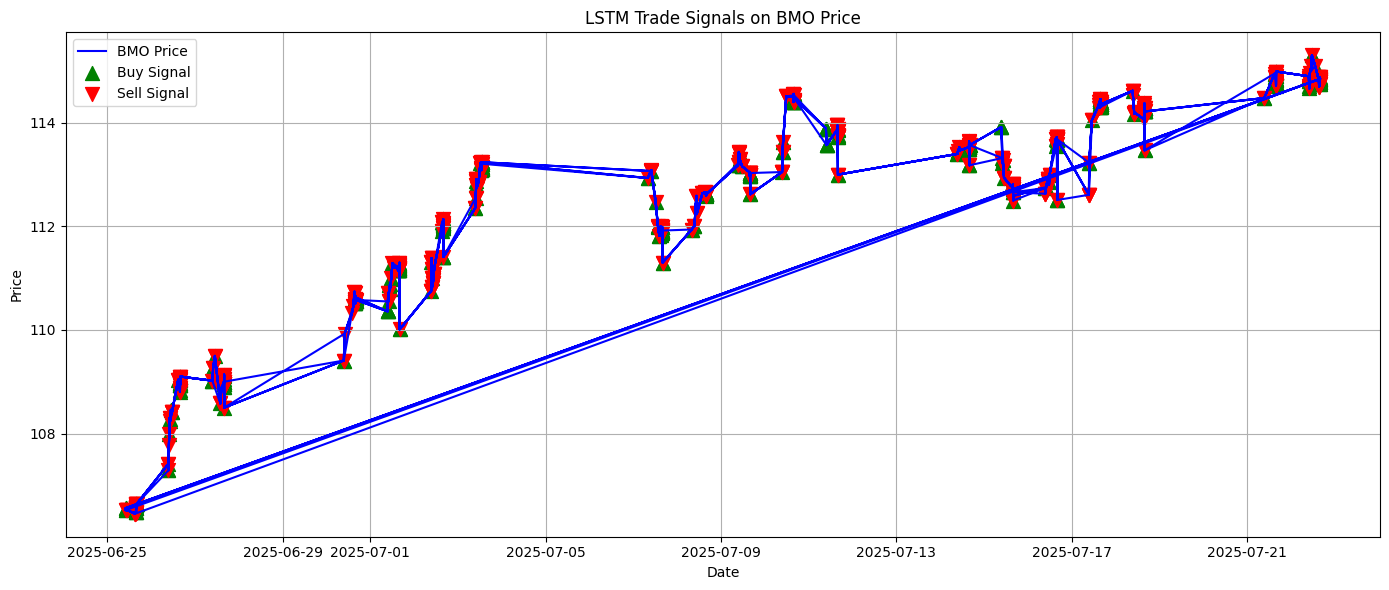

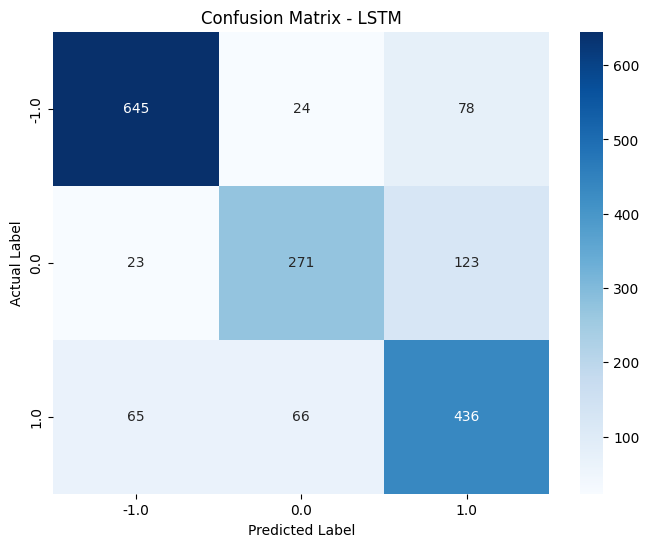

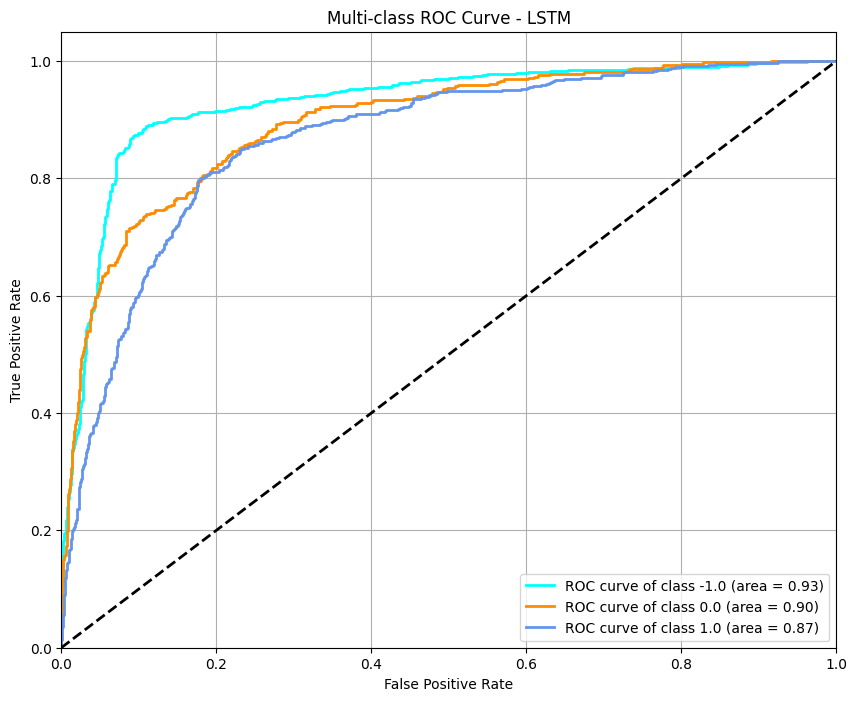

In [ ]:
# Helper to create LSTM sequences
def create_sequences(X, y, sequence_length):
    Xs, ys, indices = [], [], []
    for i in range(len(X) - sequence_length):
        Xs.append(X[i:i+sequence_length])
        ys.append(y[i+sequence_length])
        indices.append(i + sequence_length)
    return np.array(Xs), np.array(ys), np.array(indices)

# Model definition
# Model definition
@register_keras_serializable()
class LastHiddenState(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        return inputs[:, -1, :]

    def get_config(self):
        config = super().get_config()
        return config

@register_keras_serializable()
class AttentionWeightedSum(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        lstm_outputs, attention_weights = inputs
        return tf.reduce_sum(lstm_outputs * attention_weights, axis=1)

    def get_config(self):
        config = super().get_config()
        return config

@register_keras_serializable()
class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.dense = layers.Dense(1, activation='tanh')

    def call(self, inputs):
        score = self.dense(inputs)
        weights = tf.nn.softmax(score, axis=1)
        return weights

    def get_config(self):
        config = super().get_config()
        return config


def build_simple_lstm(sequence_length, n_features, num_classes=3):
    inputs = layers.Input(shape=(sequence_length, n_features))
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.2))(inputs)
    x = layers.LayerNormalization()(x)
    attention_weights = AttentionLayer()(x)
    attended = AttentionWeightedSum()([x, attention_weights])
    last_hidden = LastHiddenState()(x)
    combined = layers.Concatenate()([attended, last_hidden])
    combined = layers.Dropout(0.3)(combined)
    x = layers.Dense(16, activation='relu')(combined)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    return model


# Main training function
def train_rnn(features_df, sequence_length=20):
    features_df_original = features_df.copy()
    features_df.dropna(inplace=True)

    # Features and labels
    feature_cols = ['spread', 'zscore', 'std', 'volatility', 'momentum', 'rolling_corr']
    X = features_df[feature_cols].values
    y = features_df['signal'].values

    # Encode signal
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Normalize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Sequence preparation
    X_seq, y_seq, indices_seq = create_sequences(X_scaled, y_encoded, sequence_length)

    # Split (no shuffle)
    split_idx = int(0.8 * len(X_seq))
    X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
    y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]
    indices_train, indices_test = indices_seq[:split_idx], indices_seq[split_idx:]

    # Build and compile model (use sparse loss)
    model = build_simple_lstm(sequence_length, X_seq.shape[2])

    # Compile with sparse categorical crossentropy
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Checkpoint to save best model
    checkpoint_path = 'best_rnn_model.keras'
    checkpoint_cb = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    # Compute class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = dict(enumerate(class_weights))

    # Train
    model.fit(
        X_train, y_train,
        epochs=30, batch_size=64,
        validation_data=(X_test, y_test),
        callbacks=[checkpoint_cb],
        class_weight=class_weight_dict,
        verbose=1
    )

    # Reload best model
    model = load_model(checkpoint_path)

    # Predict
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    decoded_preds = le.inverse_transform(y_pred)

    # Classification report
    print("\nLSTM Backtest Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_.astype(str)))

    # Prepare aligned test DataFrame using indices
    test_df_for_backtest = features_df_original.iloc[indices_test].copy()

    # Backtest and plot
    backtest = backtest_with_predictions(test_df=test_df_for_backtest, predictions=decoded_preds)
    plot_model_signals(decoded_preds, features_df_original.iloc[indices_test], stock_a, close_prices, model_name="LSTM")
    class_labels = le.classes_
    plot_confusion_matrix(y_test, y_pred, class_names=class_labels, model_name="LSTM")
    plot_roc_curve(y_test, y_pred_probs, class_names=class_labels, model_name="LSTM")

    return model, scaler


rnn_model, rnn_scaler = train_rnn(labeled_features)